## Project Title: 
### Twitter NLP Analysis

## Creator: 
### Daniel Ramirez Jr.

## Project Type:

### Personal

## 1. Problem Introduction
---

Sneakers have become an asset that can be traded as if they are stocks, bonds, and commondities. There are several factors that drive the post-retail price of a sneaker, but a main factor is how the public perceives the sneaker itself. Humans have this tendency to belong to a certain community and look like their fellow members. Thus, if an important person in one's community is pitching a certain look, the community is likely to mimick that style.

In the past, the hype on the streets was what made a sneaker popular, but now it has transitioned into social media platforms such as Instagram and Twitter. The goal of this analysis is to provide descriptive analytics regarding a sneaker that is talked about on Twitter. The two main questions that this analysis will answer are: 

1. Can hype be measured?

2. If hype can be measured, can it help predict the price of a post-retail sneaker price? 

## 3. Dataset
---

In [4]:
#required libraries for analysis
#twitter library was used to connect to the Standard Twitter API and pull data
import twitter

#import pandas for data manipulation
import pandas as pd

#stat functions
from statistics import mean
from statistics import median
from statistics import stdev

#used for saving files and manipulating data structures
import json

#used for descriptive statistics section
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#import the word cloud functions
from wordcloud import WordCloud, STOPWORDS

#begin describing the most popular tweets in the dataset (these will most likley all be retweets)

#Counter library will give us frequency information
from collections import Counter
import numpy as np

#stopwords
import nltk

#SentimentIntensityAnalyzer is python's library that can peform sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Topic Analysis: What is the general gest of the tweets in the dataset?
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer

#library for clustering
import sklearn.cluster as cl

#perform the cosine similarity between each candidate
from sklearn.metrics.pairwise import cosine_similarity

#import the time function so that the main function can display the visuals propely
import time

### 3.1. Data Source

To support the argument that social media analytics can provide value to music managers and artists, the project analyzed Tweets that contained the name of a specific shoe that is


The Standard Twitter API had a limit on how many Tweets could be gathered; around 500,000 Tweets per month. Other restrictions were related to time constraints. For example, to pull data from the Standard Twitter API, one has to make a request to the API, however, all request windows were 15 minutes in length, meaning that one had to be mindful on how many Tweets were being pulled and when.

### 3.2. Authorization of Twitter Developer Account

This section created a function that connected the Twitter Developer Account information with the Standard Twitter API. In other words, the Standard Twitter API authorized the account to ensure it could provide data.

In [5]:
#function that authorizes the twitter account
#parameters include the user's personal information provided in the developer account portal
def oauth_login(CONSUMER_KEY,CONSUMER_SECRET,OAUTH_TOKEN,OAUTH_TOKEN_SECRET):
    # See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
    # for more information on Twitter's OAuth implementation.
    #authorizing your request
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    #connects you to the api
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

In [6]:
#key values
CONSUMER_KEY = '42oR4YzLBYPJE0P6fz3Tldal3'
CONSUMER_SECRET = 'HHRMTiqYib6VoV7qGi6jSSQZigOMz2tGzFyUb5Smpjf1CAfh6h'
OAUTH_TOKEN = '824794621180047360-uQdy9rbC1bAFZCAonxZWJh33ZZEIkJb'
OAUTH_TOKEN_SECRET = 'tS6LJoa0B9UlukJoosJVQDy67COoHq2dsV2hShiMceleN'

# store the function to the twitter_api variable
twitter_api = oauth_login(CONSUMER_KEY,CONSUMER_SECRET,OAUTH_TOKEN,OAUTH_TOKEN_SECRET)    

print(twitter_api)

### 3.3. Pulling Data From The Standard Twitter API

To pull a specific amount of Tweets, based on a certain criteria, the twitter_search function was created. The parameters include the variable that contains the user's permission to pull from the Twitter API (twitter_api), the search query (q), the total amount of tweets to pull (max_results), and the keyword arguments variable (** kw) because it is not certain how many arguments are goingt to be placed in the function calling.

The function's object was to pull Tweets that contained the name 'Ariana Grande' using Twitter's "search.tweets" function. Search.tweets returns a large JSON structure that has a key labeled 'statuses'. This key holds a value that contains a list of all the dictionaries that pertain to the Tweets pulled from the Twitter API. 

In [7]:
#function that searches for what the user asks
def twitter_search(twitter_api, q, max_results=100, **kw):
    # See https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets
    # and https://developer.twitter.com/en/docs/tweets/search/guides/standard-operators
    # for details on advanced search criteria that may be useful for 
    # keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    #Returns tweets created before the given date. Date should be formatted as YYYY-MM-DD. 
    #Keep in mind that the search index has a 7-day limit. 
    #In other words, no tweets will be found for a date older than one week.
    
    #search_results is the variable that will hold the values that are returned by the search function from the twitter_api library
    search_results = twitter_api.search.tweets(q=q,lang='en',count=100, **kw)
    
    #assign the statuses variable to the list of Tweets pulled from the API 
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://developer.twitter.com/en/docs/basics/rate-limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError as e: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

In [8]:
#This cell calls the twitter api and stores the data in the variable statutes; be careful be careful when using it. You could exceed the API limit by accident
#########################################################################

#assign the sneaker name to a variable
sneaker_name = 'Cool Greys'

#exclude replies, retweets, urls; just original tweets
#urls are excluded because the same tweets are provided but with different URLS, thus messing up the unique count
filtering_criteria = '-is:retweets -filter:links'

#build the query that looks for the sneaker name and that excludes replies, retweets,urls
query = sneaker_name + filtering_criteria
print(query)
#variable below makes the request and stores the JSON Format aka dictionary structure
dictionary_of_tweets = twitter_search(twitter_api, query)

#print tweet count
print('Tweet Count: ',len(dictionary_of_tweets))
print()

#display the first dictionary in the list of dictionaries that contain all the tweet information returned by the twitter API
dictionary_of_tweets[0]

Cool Greys-is:retweets -filter:links
Tweet Count:  100



{'created_at': 'Mon Nov 08 16:02:02 +0000 2021',
 'id': 1457740204769484811,
 'id_str': '1457740204769484811',
 'text': '@SoThatsSlim i’ve been on the fence about the cool greys.. which is weird because it used to be one of my favorites.',
 'truncated': False,
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [{'screen_name': 'SoThatsSlim',
    'name': 'slim.',
    'id': 71395659,
    'id_str': '71395659',
    'indices': [0, 12]}],
  'urls': []},
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'in_reply_to_status_id': 1457737347055902727,
 'in_reply_to_status_id_str': '1457737347055902727',
 'in_reply_to_user_id': 71395659,
 'in_reply_to_user_id_str': '71395659',
 'in_reply_to_screen_name': 'SoThatsSlim',
 'user': {'id': 1062527266536730624,
  'id_str': '1062527266536730624',
  'name': 'roddie',
  'screen_name': 'roddiecooper',
  'location': 'New Orleans,

### 3.4.  Storing the Unstructured Data From The Standard Twitter API

Given that Twitter Data is valuable and the API request was limited, it was important to save the raw data immediately in case the notebook file crashes or is lost somehow.


In [6]:
#save the raw data into a file on your computer

#the last section of the path is the new name of the file
raw_file_name = 'rawTwitterData.json'

#save the raw data to the following path location
path = 'C:/Users/Papi/Documents/Data Science Projects/Data_Science_Projects/Twitter Data Mining/'

full_path = path +raw_file_name

#dump the list of dictionaries into a new json file in the path above 
with open(full_path, 'w') as fout:
    json.dump(dictionary_of_tweets, fout)



### 3.5. Pre-Processing Unstructured Twitter Data

The Standard Twitter API provided a siginificant amount of data points that were irrelevant to the scope of the project's analysis. The project was specifically interested in the following variables from each Tweet pulled:

- User screen name
- Text content of Tweet
- Amount of followers the user has
- Date of the Tweet
- Amount of likes the Tweet received  
- Amount of Retweets the Tweet received  

In [7]:
#this function gathers the relevant information that is pulled from the twitter_search function 
def relevantTweetInfo(raw_dictionary):
    #create the list where all the dictionary of tweets are going to be stored
    tweets = []

    # create a json structure for this so that we can get corresponding attributes from the twitter data
    #the points of interest of the twitter data are as follows:
    
    #it is important to know who is talking about the sneaker and how influencial they may be. This can be found by the follower count and how the public reaction to thier tweet
    filtered_tweets = {  
        'Screen_Name': 0,
        'Tweet': 0,
        'Followers':0,
        'Date':0,
        'Likes':0,
        'Retweets':0
        }

    #create a for loop that goes into each
    for status in raw_dictionary:

        #takes the dictionary values from the raw data and assigns it to the clean dictionary
        filtered_tweets['Screen_Name'] = status['user']['screen_name']
        filtered_tweets['Tweet'] = status['text']
        filtered_tweets['Followers'] = status['user']['followers_count']
        filtered_tweets['Date'] = status['user']['created_at']
        filtered_tweets['Likes'] = status['favorite_count']
        filtered_tweets['Retweets'] = status['retweet_count']

        #appends the dictionary, that pertains to a specific tweet, to the list_of_random_tweets
        tweets.append(filtered_tweets.copy())
    
    #return the list of dictionaries that contain the relevant information that will be used for analysis
    return tweets


In [8]:
#test the function that takes the relevant information
test_relevantTweetInfo = relevantTweetInfo(dictionary_of_tweets)
print('Tweet Count: ',len(test_relevantTweetInfo))
print()

#show case the first dicitonary in the list
test_relevantTweetInfo[0]

Tweet Count:  100



{'Screen_Name': 'GSCnMe',
 'Tweet': '@RaDadtouille But with those undertones, you want to stay away cool greys',
 'Followers': 13,
 'Date': 'Tue Dec 29 12:36:12 +0000 2020',
 'Likes': 0,
 'Retweets': 0}

### 3.6. Storing the Processed Data From The Standard Twitter API

The cleansed, processed data was saved in the case that something were to occur.

In [9]:
#save the relevant data to the following location

#the last section of the path is the new name of the file
clean_file_name = 'TwitterData.json'

#save the raw data to the following path location

clean_path = path + clean_file_name

#dump the list of dictionaries into a new json file in the path above 
with open(clean_path, 'w') as fout:
    json.dump(test_relevantTweetInfo, fout)

### 3.7. Retrieving Unique Tweets
This section derives unique tweets, and their respective characteristics, from the list of dictionaries that contains random timeframes, users, locations, and duplicated tweets that are returned by the Standard Twitter API. 

In [10]:
#function that provides a list of list that contain unique tweets and their relevant characteristics such as the date, username, follower count, and retweet count of that specific unique tweet
def uniqueTweetInformation(list_of_dictionaries):
    #master dictionary that will contain the relevant information of the unique tweets in the dataset (keys are the same as last dictionary and values are lists)
    master_dictionary = {  
        'Screen_Name': 0,
        'Tweet': '',
        'Followers':0,
        'Date':0,
        'Likes':0,
        'Retweets':0
        }
    
    #count the tweets that were identical in the dataset, both tweets and retweets because duplicates will throw off our analysis
    #list that only contains unique dictionary tweets (list of unique dictionary tweets)
    unique_tweets = []
    
    #list that contains unique text (list of unique text/string)
    unique_text = []
    
    #loop through each tweet dictionary in the list of dictionaries
    for tweet in list_of_dictionaries:
        #if the tweet is not in the list of unique texts then add it to the list
        if tweet.get('Tweet') not in unique_text:
            #append to respective lists
            unique_text.append(tweet.get('Tweet'))
            unique_tweets.append(tweet)    

    
    ###############################################################
    #now that there a list of unique text, the numeric values can be stored
    #if numeric values were stored for reoccuring tweets, the analysis would over value certain tweets

    #lists where the remaining attributes will be stored
    screen_names = []
    followers = []    
    string_dates = []
    retweet_count = []
    likes = []
    
    #loop through each unique tweet in the list of unique tweets
    for uniqueTweet in unique_tweets:
        #key_list has the attributes of the tweet
        # key_list looks like this ['Screen_Name', 'Tweet', 'Followers', 'Date', 'Likes', 'Retweets']
        key_list = list(uniqueTweet.keys())

        #assign values from unique_tweets to the following variables
        name_section = uniqueTweet[key_list[0]]
        follower_section = uniqueTweet[key_list[2]]
        date_section = uniqueTweet[key_list[3]]
        likes_section = uniqueTweet[key_list[4]]
        retweet_section = uniqueTweet[key_list[5]]

        #append those values to the corresponding lists
        screen_names.append(name_section)
        followers.append(follower_section)
        string_dates.append(date_section)
        likes.append(likes_section)
        retweet_count.append(retweet_section)
    
    #loop has ended and the list are ready to be appended to the master list
    #append the respective lists into the master list:
    master_dictionary['Screen_Name'] = screen_names
    master_dictionary['Tweet'] = unique_text
    master_dictionary['Followers'] = followers
    master_dictionary['Date'] = string_dates
    master_dictionary['Likes'] = likes
    master_dictionary['Retweets'] = retweet_count

    ###############################################################
        

    #convert the dictionary into a readable dataframe
    tweet_table = pd.DataFrame(master_dictionary)
        
    #sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content.
    tweet_table = tweet_table[~tweet_table.Tweet.str.contains("RT")]
    
    #length of filtered table
    total_unique_tweets = tweet_table.shape[0] 
       
    #printing out how many tweets are unique        
    total_tweets_pulled = len(list_of_dictionaries)
    
    #actual amount of unique tweets that exclude the user RT
    unique_ratio = round((total_unique_tweets/total_tweets_pulled)*100)

    print('Amount of Total Tweets:',total_tweets_pulled)       
    print('Amount of Unique Tweets:',total_unique_tweets)
    print('Unique Tweets Percentage: %i'%(unique_ratio))
    
    #return the dataframe that is derived from the master dictionary
    return tweet_table

In [11]:
#create an instance of the function
test_uniqueTweetInformation = uniqueTweetInformation(test_relevantTweetInfo)

#display the first dictionary in the list of unique dictionaries
test_uniqueTweetInformation.head(5)

Amount of Total Tweets: 100
Amount of Unique Tweets: 95
Unique Tweets Percentage: 95


,Screen_Name,Tweet,Followers,Date,Likes,Retweets
0,GSCnMe,"@RaDadtouille But with those undertones, you w...",13,Tue Dec 29 12:36:12 +0000 2020,0,0
1,keonanicholson1,He better get my cool greys and my baby a pair...,230,Thu Nov 28 23:28:47 +0000 2013,0,0
2,kjuggzz,If yu love me get me them cool greys early,445,Thu Mar 17 15:23:37 +0000 2016,0,0
3,Real1Keez,Taxis ✅ .. jus need dem Cool greys and Breds d...,268,Wed Aug 05 01:14:14 +0000 2020,0,0
4,Ototha,@thakid_Jonny Cool Greys?,1086,Fri Apr 01 00:12:29 +0000 2011,0,0


## 4. Descriptive Analytics
---

### 4.1. Data Distribution

In [12]:
#create a function that takes in a dataframe of the unique tweets and provides histograms to show data distributions
def dataDistributions(dataFrame):
    #create a copy to manipulate
    dfCopy =  dataFrame.copy(deep = True)
    
    #get the instance count
    instance_count = dfCopy.shape[0]
    
    #let the user know how many data points are in the data 
    print('There are %i instances in the dataset:\n'%(instance_count))
   
    #numerical columns include Followers, Likes, Retweets:
    #follower distribution
    dfCopy.hist(column='Followers',bins="auto",grid=True)
    

    #Likes distribution
    dfCopy.hist(column='Likes',bins="auto",grid=True)
    
    #Retweet distribution
    dfCopy.hist(column='Retweets',bins="auto",grid=True)

There are 95 instances in the dataset:



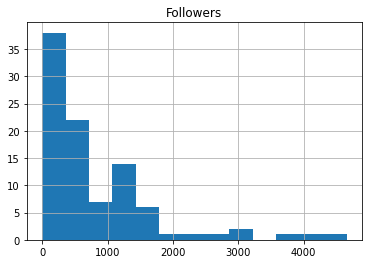

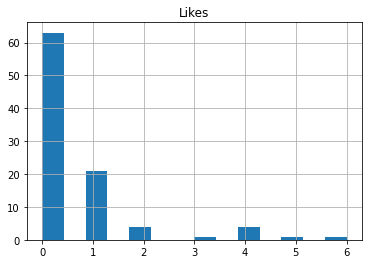

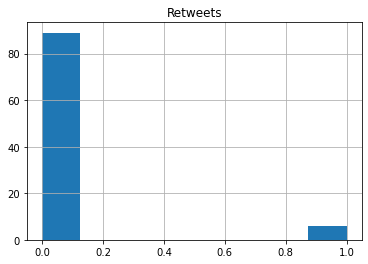

In [13]:
test_dataDistributions = dataDistributions(test_uniqueTweetInformation)
test_dataDistributions;

### 4.2. Word Cloud

A word cloud can be used to visually represent the most common words in a dataset. Understanding the most popular words used in conjunction with the name of a sneaker can provide an investor with a preliminary understanding of how the general public might feel about the sneaker

In [14]:
test_uniqueTweetInformation['Tweet'][0:5]

0    @RaDadtouille But with those undertones, you w...
1    He better get my cool greys and my baby a pair...
2           If yu love me get me them cool greys early
3    Taxis ✅ .. jus need dem Cool greys and Breds d...
4                            @thakid_Jonny Cool Greys?
Name: Tweet, dtype: object

In [15]:
#Show the most frequent words used in the dataset using a word cloud
# Define a function to plot word cloud
def plot_cloud(dictionary_tweet_value):
    #to do this, join all the string elements in the list into one large string
    #specify how to join them, in this case by space
    cloud_string = " "  

    #use the list from the master dictionary
    cloud_string = cloud_string.join(dictionary_tweet_value)
    
    #generate a wordCloud with the function below
    wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(cloud_string)
    
    # Set figure size
    plt.figure(figsize=(10, 20))
    
    # Display image
    plt.imshow(wordcloud) 
    
    # No axis details
    plt.axis("off");

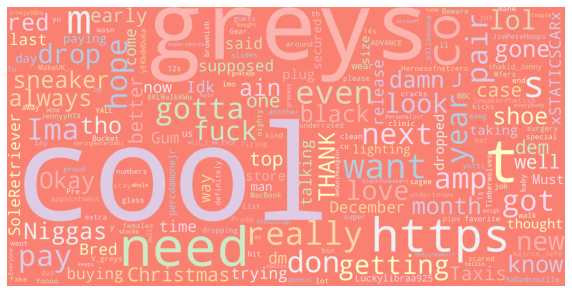

In [16]:
test_plot_cloud = plot_cloud(test_uniqueTweetInformation['Tweet'])

### 4.3. Influence Distribution

Twitter API provides Tweets from random people that have a wide range of followers. To better interpret the distribution, a pie chart was created that contained similar bucket. This helps visualize how influencial the users are in our sample. If someone's influence is big, then what they say about a sneaker can be very important.

In [17]:
#create a function that produces a pie chart with the follower column in the dataframe
def influenceChart(dataFrame):
    #make a copy
    dfCopy = dataFrame.copy(deep = True)
    
    #break down the follower column into respective sections:
    value1 = len(dfCopy.loc[dfCopy['Followers'] <100])
    value2 = len(dfCopy.loc[(dfCopy['Followers'] >=100) & (dfCopy['Followers'] <=500)])
    value3 = len(dfCopy.loc[(dfCopy['Followers'] >500) & (dfCopy['Followers'] <=1000)])
    value4 = len(dfCopy.loc[(dfCopy['Followers'] >1000) & (dfCopy['Followers'] <=10000)])
    value5 = len(dfCopy.loc[dfCopy['Followers'] >10000])
    
    #prepare the piechart with labels and values
    my_data = [value1,value2,value3, value4,value5]
    my_labels = 'Less than 100','100 to 500','501 to 1,000','1,001 to 10K','Greater than 10K'

    plt.title('Influence by the Number')
    plt.axis('equal')

    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','red']
    patches = plt.pie(my_data, colors=colors,autopct='%1.0f%%',pctdistance=1.2);

    plt.legend(bbox_to_anchor=(1,1), labels=my_labels);

    figure(figsize=(50, 10), dpi=80);

    plt.show();


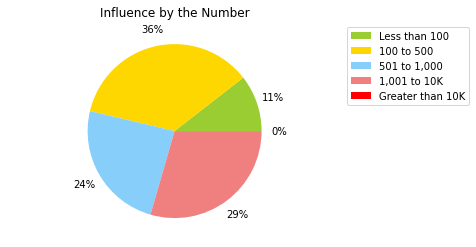

<Figure size 4000x800 with 0 Axes>

In [18]:
test_influenceChart = influenceChart(test_uniqueTweetInformation)
test_influenceChart

In [66]:
#create descriptive analytics function that displays 3 historgrams, a wordcloud, and 1 pie chart
def descriptiveAnalytics(histograms,wordcloud,piechart):
#     return(histograms,wordcloud,piechart)
#     #print the histogram
#     display(histograms)
#     print()
#     display(wordcloud)
#     print()
#     display(piechart)

    

In [67]:
#display the function

test_descriptiveAnalytics = (test_dataDistributions,test_plot_cloud,test_influenceChart)
test_descriptiveAnalytics

(None, None, None)

In [19]:
#show how the age of the tweets are distributed in the dataset
print('Age Breakdown of Tweets:')
print('-------------------------')
print()
print('The oldest year in our sample was',min(dates))    
print('The most recent year in our sample was',max(dates))
print()

#create a bar graph to see how many of the tweets were associated with what year 

#this for loop creates a list with the proper dates
date_range = []
for fecha in range(min(dates),max(dates)+1):
    date_range.append(fecha)
    
#this loop gets a count of the specific labels in the list of dates
values_for_bgraph = []
for fecha in date_range:
    year_count = dates.count(fecha)
    values_for_bgraph.append(year_count)

    
plt.bar(date_range, values_for_bgraph)    
plt.title('Timeframe of Unique Tweets')
plt.xlabel('Year of Tweet')
plt.ylabel('Amount of Tweets')
plt.show()

Age Breakdown of Tweets:
-------------------------



NameError: name 'dates' is not defined

### 5. Data Cleansing for Analysis
---
The descriptive section ends here and now the goal is to clean the Tweets from the text data located in the unique_text list that contains all the Tweets that are unique in the dataset. After cleaning, the text will undergo sentiment analysis and a breakdown of how many Tweets were positive and negative will be counted for. Moreover, the analysis will also attempt to find connections between the Tweets, specifically through key words and topics. 


In [20]:
tweets = test_uniqueTweetInformation[['Tweet']]
tweets.head()

,Tweet
0,"@RaDadtouille But with those undertones, you w..."
1,He better get my cool greys and my baby a pair...
2,If yu love me get me them cool greys early
3,Taxis ✅ .. jus need dem Cool greys and Breds d...
4,@thakid_Jonny Cool Greys?


In [21]:
#create a function that tokenizes the text and prepares the words for analysis
#function that removes stopwords from 
def removeStopWords(tokenized_list):
        
    #assign a variable to a list that contains all the stopword associated with the nltk library
    stopwords = nltk.corpus.stopwords.words('english')
    
    #trigger = True
    clean_word_list = []
    
    #token represents a word or small phrase
    for token in tokenized_list:       
        #stopwords and tweets with links will not be used in the analysis 
        #also the user @name is removed from the text and it will most always be the first character in the tweet
        #a tweet that is a mention will most always begins with the "@"
        #as well because the focus is on the content and its sentiment
        if token not in stopwords and 'http' not in token and tokenized_list[0]!= '@':
            #append the clean word to the lsit of clean words
            clean_word_list.append(token)
    
    #since each list represents a sentence broken down in tokens, it must be joined together to analyze properly
    listToStr = ' '.join(map(str, clean_word_list))
    
    #return the clean list that will be analyzed for sentiment
    return listToStr

In [22]:
sample_text = ['http', '@','the','cat', 'in', 'the' , 'da', 'hat', 'brother']

test_removeStopWords = removeStopWords (sample_text)
test_removeStopWords

'@ cat da hat brother'

In [23]:
#create a function that cleans text
def textCleaner(dataFrame,stopWordFunction):
    #make copy
    dfCopy = dataFrame.copy(deep = True)    
    
    #drop the rows that have na
    dfCopy.dropna(inplace=True)
     
    #convert to lowercase
    dfCopy['Tweet'] = dfCopy['Tweet'].str.lower()
    
    #replace numbers - '\d+' refers to all digits with white space
    dfCopy['Tweet'] = dfCopy['Tweet'].str.replace('\d+', '')    

    #remove punctuation - '[^\w\s]' refers to all punctuation marks
    dfCopy['Tweet'] = dfCopy['Tweet'].str.replace('[^\w\s]', '')
        
    #Split by Space - this creates a list
    dfCopy['Tweet'] = dfCopy['Tweet'].str.split()

    #apply the stopword function
    dfCopy['Tweet'] = dfCopy['Tweet'].apply(stopWordFunction)

    #return the final clean version of the text
    return dfCopy 

In [24]:
test_textCleaner = textCleaner(test_uniqueTweetInformation,removeStopWords)
test_textCleaner.head()

,Screen_Name,Tweet,Followers,Date,Likes,Retweets
0,GSCnMe,radadtouille undertones want stay away cool greys,13,Tue Dec 29 12:36:12 +0000 2020,0,0
1,keonanicholson1,better get cool greys baby pair,230,Thu Nov 28 23:28:47 +0000 2013,0,0
2,kjuggzz,yu love get cool greys early,445,Thu Mar 17 15:23:37 +0000 2016,0,0
3,Real1Keez,taxis jus need dem cool greys breds das dropping,268,Wed Aug 05 01:14:14 +0000 2020,0,0
4,Ototha,thakid_jonny cool greys,1086,Fri Apr 01 00:12:29 +0000 2011,0,0


### 6. Text-Analysis
---
Sentiment, Topic, and Vector Analysis. Sentiment Analysis includes the Vader Compound Score, which takes into account positive, negative, and neutral scores, and merges them together for a new score. In addition, the Net Sentiment Rate metric will be used to provide a better understanding of what the sentiment is in the dataset. A positive NSR indicator is a score above 0, while a negative NSR indicator is a score below 0. 

### 6.1 Vader Sentiment-Analysis


In [25]:
#create a function for vader sentiment analysis on clean text
def vaderSentimentAnalysis(dataFrame):
    #make a copy for manipulation
    dfCopy = dataFrame.copy(deep = True)
    
    #create an instance of the vader analyzer 
    analyzer = SentimentIntensityAnalyzer()
    
    #create a new column that contains the Vader Sentiment Analysis
    dfCopy['Sentiment Vader Score'] =dfCopy['Tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    
    #display the dataframe
    display(dfCopy.head(5))
    print()

    #create the visual section that contains a pie graph and boxplot:
    
    #show the vader sentiment score on a pie graph to show the breakdown
    positive = []
    negative = [] 
    neutral = []
    
    #create the buckets for analysis
    for vader in dfCopy['Sentiment Vader Score']:

        if vader >=0.10:
            positive.append(vader)

        elif vader <= -0.10:
            negative.append(vader)

        else:
            neutral.append(vader)
    
    #Calculate NSR
    positive_count = len(positive)
    negative_count = len(negative)
    neutral_count = len(neutral)
    nsr_score = (positive_count-negative_count)/(positive_count+neutral_count)
    
    print('The NSR score for all the %i unique tweets in the data set is %f.'%(dfCopy.shape[0],round(nsr_score,2)*100))

    my_data = [positive_count,negative_count,neutral_count]
    my_labels = ['Positive','Negative','Neutral'];

    plt.title('Vader Sentiment Score Breakdown');
    plt.axis('equal');

    colors = ['yellowgreen', 'red', 'gray'];
    patches = plt.pie(my_data, colors=colors,autopct='%1.0f%%',pctdistance=1.2);

    plt.legend(bbox_to_anchor=(1,1), labels=my_labels);

    figure(figsize=(50, 10), dpi=80);

    plt.show();
    print()
    
    #visualize the performance
    dfCopy.boxplot(column=['Sentiment Vader Score'], patch_artist=True, grid = True,showfliers=False,showmeans=True,return_type='axes');
    
    return dfCopy


,Screen_Name,Tweet,Followers,Date,Likes,Retweets,Sentiment Vader Score
0,GSCnMe,radadtouille undertones want stay away cool greys,13,Tue Dec 29 12:36:12 +0000 2020,0,0,0.3818
1,keonanicholson1,better get cool greys baby pair,230,Thu Nov 28 23:28:47 +0000 2013,0,0,0.6369
2,kjuggzz,yu love get cool greys early,445,Thu Mar 17 15:23:37 +0000 2016,0,0,0.7579
3,Real1Keez,taxis jus need dem cool greys breds das dropping,268,Wed Aug 05 01:14:14 +0000 2020,0,0,0.3182
4,Ototha,thakid_jonny cool greys,1086,Fri Apr 01 00:12:29 +0000 2011,0,0,0.3182



The NSR score for all the 95 unique tweets in the data set is 77.000000.


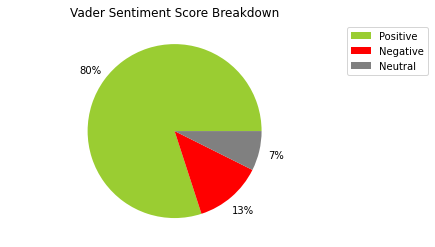

<Figure size 4000x800 with 0 Axes>

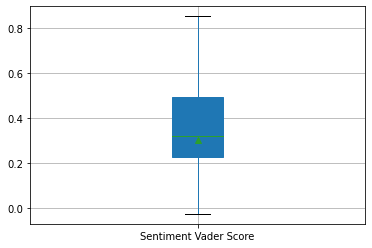

In [26]:
test_vaderSentimentAnalysis = vaderSentimentAnalysis(test_textCleaner);


### 6.2 Topic Modeling (K-Means)


In [27]:
#create a function for k-means calculations
def topicModeling(dataFrame):
    #create copy
    dfCopy = dataFrame.copy(deep=True)
    
    #create an instance of the CountVectorizer which will be referenced later by the fit_transform
    count_vector = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.01)
    
    #seperate the text column
    text_column = dfCopy.iloc[:,1]

    #this is essentially the term-frequency matrix
    #line below creates an array that contains the text documents as rows and the words (aka features) as columns
    df_bag = count_vector.fit_transform(text_column)
    
    #the fit transform needs to be changed into an array that contains the column values for the data frame
    count_array = df_bag.toarray()
    
    #column titles
    feature_names = count_vector.get_feature_names()

    #create the TF table
    term_frequency_table = pd.DataFrame(data=count_array,columns = feature_names)
    
#     print('The Term Frequency Matrix has %i documents (rows) and %i unique terms (columns).'%(term_frequency_table.shape[0],term_frequency_table.shape[1]))
    
    #display the term frequency table
#     display(term_frequency_table.head())
    print()
    
    ############################    
    #create an instance of the Kmeans method from the cl library and choose how many clusters to create
    clusters = cl.KMeans(n_clusters=5)

    #apply the data to the k means algoirthm
    clusters.fit(df_bag)

    #creates an array where rows pertain to the specific cluster and the columns pertain to the unique terms found in the tweets 
    #for each cluster, the centeriod is calculated for every term
    cluster_array = clusters.cluster_centers_
    
#     #print some descriptive information
#     print('There are %i clusters with %i unique terms with a corresponding centeriod.'%(clusters.cluster_centers_.shape[0],clusters.cluster_centers_.shape[1]))
#     print()
    #create the cluster table
    cluster_table = pd.DataFrame(data=cluster_array, columns = feature_names)
#     print('Cluster Table')
#     print()
#     display(cluster_table)
    
    #argsort() retrieves the position of the element that corresponds to a value in decending order
    #for example, the first number given pertains to the index position where the lowest value is located in that specific list 
    lowest_highest_indexes = cluster_array.argsort()
#     print()
#     print('Row values contain the index')
#     print(lowest_highest_indexes)
    
    #create the aregsort table
    argSort_table = pd.DataFrame(data=lowest_highest_indexes, columns = feature_names)
#     display(argSort_table)

    #take the top 
    n_top_words = 10
    
    #since the the r
    important_positions = lowest_highest_indexes[:, :-n_top_words-1:-1] 
    
    print()
    print('The following Clusters represent different topics:')
    print('-----------------------------------------------------')
    print()
    order_centroids = lowest_highest_indexes[:, ::-1] 
    for i in range(5):
        print("Topic %d:\n\n" %(i +1), end='')
        print(" ".join([feature_names[j] for j in cluster_array[i].argsort()[:-n_top_words - 1:-1]]))
        print()

#     #     return (term_frequency_table)

In [28]:
test_topicModeling = topicModeling(test_textCleaner) 
test_topicModeling



The following Clusters represent different topics:
-----------------------------------------------------

Topic 1:

im want really like gotta year pair amp getting hope

Topic 2:

damn percdamonejr tall price im wear oh ass lol retail

Topic 3:

need got fuck new dont outta date das fuckin stfu

Topic 4:

gorgeous aaaaa lighting thank drawing colors sony_shock love getting fu

Topic 5:

tho got pay chicks ima tryna luckylibraa getting fuck fuckin



### 6.3 Vector Analysis (Co-Sign Similarity)
---
This section will seek to find similarities among the positive and negative Tweets using the co-sign similarity concept. This analysis is assuming that compounded Vader Sentiment Scores greater than or equal to 0.65 are positive. Moreover, a negative score would yield a value less than 0. The goal here is to find out what Tweets were similar and what key words were present in those Tweets. 

In [55]:
#create a function for co-sign similarity
def cosignSimilarity(dataFrame,directionType):
    #create copy
    dfCopy = dataFrame.copy(deep = True)
    
    
    #if the user wants to find trends in the positive tweets
    if directionType == '1':
        #find similarities among the positive and negative tweets using vector analysis, co-sign similarity concept
        #Sentiment Scores greater than or equal to 0.65 are deemed po
        textDf = dfCopy.loc[dfCopy['Sentiment Vader Score'] >=0.65]
        
        #change value to string for printing purposes
        directionType = 'Positive'
    
    
    #if the user wants find trends in the negative tweets
    elif directionType == '2':
        #vader sentiment of less than 0 can 
        textDf = dfCopy.loc[dfCopy['Sentiment Vader Score'] <0]
        
        #change value to string for printing purposes
        directionType = 'Negative'
    
    #break the function if the user doesn't put a valid option
    else:
        return None
    
    
    #text values that have a vader score greater than or equal to 0.65
    text = textDf['Tweet']
    
    #create an instance of the CountVectorizer which will be referenced later by the fit_transform
    count_vector = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.01)
    
    #create the data that represents the term frequency
    df_bag = count_vector.fit_transform(text)
    print('Fit_Transform Variable Output')
    print()
    print(df_bag)
    print()
    print('Lists of Lists where the length of the outter lists represents the total documents in the dataset, and the length of the nested list represents the amount of unique terms in the data set')    
    print()
    #it is necessary to create an array first so that you can create the data for the dataframe
    df_bag_array =df_bag.toarray()
    print(df_bag_array)
    
    #will be referenced later in the cosign similarity
    feature_names = count_vector.get_feature_names()
    
    #create the TF table
    term_frequency_table = pd.DataFrame(data=df_bag_array,columns=feature_names)

    #print dataframe
    print()
    print('Term Frequency Table')
    print('The Term Frequency Matrix has %i documents (rows) and %i unique terms (columns).'%(df_bag_array.shape[0],df_bag_array.shape[1]))
    print()
    display(term_frequency_table.head())
    
    
    print()
    #create co-sign similarity table
    cosign_similarity_df =pd.DataFrame(cosine_similarity(term_frequency_table, dense_output=True))
    print('Co-Sign Similarity Table 1')

#     print output
    display(cosign_similarity_df)
    print()
    
    #nullify the values that are equal to .99 and greater as cosign similarity score of that magnitude means its the same tweet
    #co-sign similarity runs from a scale of 0-1
    for column in cosign_similarity_df:
        cosign_similarity_df[column] = cosign_similarity_df[column].apply(lambda x: 0 if x >= 0.99 else x)
    
    print('Co-Sign Similarity (Final)')
    #altered dataFrame    
    display(cosign_similarity_df)
    print()
    
    
    #this list will contain all the positions of where the columns most similar document is located
    #for example, the first position in the list where index = 0, pertains to the first document
    index_positions = []
    for column in cosign_similarity_df:
        index_of_similar_doc = cosign_similarity_df[column].idxmax()
        index_positions.append(index_of_similar_doc)
    
    print('Column Index Positions of most similar Tweets')
    print(index_positions)
    print()
    
    #get the row positions
    row_positions = textDf.index

    print('Row Index Positions of most similar Tweets')
    print()
    print(row_positions)
    print()
        
    
    #loop through index positions to get the similar tweet
    print('Co-Sign Similarity among the %s Tweets'%(directionType))
    print('---------------------------------------------')
    print()

    #list of the positive texts in the cosign datframe
    text_list = []
    i = 0
    for index in index_positions:

        #print the sentences in the positive dataframe first
        print('Sentence %i: %s'%(i+1,dfCopy['Tweet'][row_positions[i]]))

        #print the sentence most similar to the sentence
        print('Sentence %i: %s'%(index,dfCopy['Tweet'][row_positions[index]]))
        text_list.append(dfCopy['Tweet'][row_positions[index]])
        print()
        i = i +1

    
    
    

In [56]:
positive_que = '1'
test_cosignSimilarity = cosignSimilarity(test_vaderSentimentAnalysis,positive_que)
test_cosignSimilarity
# test_textCleaner

Fit_Transform Variable Output

  (0, 72)	1
  (0, 41)	1
  (0, 16)	1
  (0, 26)	1
  (0, 20)	1
  (1, 16)	1
  (1, 66)	1
  (1, 42)	1
  (1, 29)	1
  (1, 69)	1
  (1, 44)	1
  (1, 53)	1
  (2, 51)	1
  (2, 3)	1
  (2, 61)	1
  (2, 68)	1
  (2, 59)	1
  (2, 27)	1
  (2, 33)	1
  (2, 36)	1
  (2, 58)	1
  (2, 8)	1
  (2, 11)	1
  (2, 32)	1
  (2, 17)	1
  :	:
  (7, 64)	1
  (7, 52)	1
  (7, 49)	1
  (7, 48)	1
  (7, 24)	1
  (7, 7)	1
  (8, 41)	1
  (8, 62)	1
  (8, 57)	1
  (8, 0)	1
  (8, 18)	1
  (8, 15)	1
  (8, 37)	1
  (8, 25)	1
  (9, 62)	1
  (9, 13)	1
  (9, 34)	1
  (9, 43)	1
  (9, 46)	1
  (9, 35)	1
  (9, 2)	2
  (9, 56)	1
  (9, 31)	1
  (9, 21)	1
  (9, 22)	1

Lists of Lists where the length of the outter lists represents the total documents in the dataset, and the length of the nested list represents the amount of unique terms in the data set

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1]
 [0 0 0 0 0 0 0 0 0 0 0 0 

,aaaaa,advance,amp,appointment,background,bright,brownish,cap,case,christmas,...,theres,toni_snow_,tons,v_greys,want,went,wow,yall,yoooo,yu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Co-Sign Similarity Table 1


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.169031,0.00000,0.248069,0.298142,0.000000,0.400000,0.424264,0.158114,0.000000
1,0.169031,1.000000,0.00000,0.104828,0.125988,0.000000,0.169031,0.119523,0.000000,0.000000
2,0.000000,0.000000,1.00000,0.000000,0.092450,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.248069,0.104828,0.00000,1.000000,0.184900,0.080064,0.248069,0.175412,0.098058,0.074125
4,0.298142,0.125988,0.09245,0.184900,1.000000,0.000000,0.447214,0.316228,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.080064,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
6,0.400000,0.169031,0.00000,0.248069,0.447214,0.000000,1.000000,0.424264,0.000000,0.000000
7,0.424264,0.119523,0.00000,0.175412,0.316228,0.000000,0.424264,1.000000,0.111803,0.000000
8,0.158114,0.000000,0.00000,0.098058,0.000000,0.000000,0.000000,0.111803,1.000000,0.094491
9,0.000000,0.000000,0.00000,0.074125,0.000000,0.000000,0.000000,0.000000,0.094491,1.000000



Co-Sign Similarity (Final)


,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.169031,0.00000,0.248069,0.298142,0.000000,0.400000,0.424264,0.158114,0.000000
1,0.169031,0.000000,0.00000,0.104828,0.125988,0.000000,0.169031,0.119523,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.092450,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.248069,0.104828,0.00000,0.000000,0.184900,0.080064,0.248069,0.175412,0.098058,0.074125
4,0.298142,0.125988,0.09245,0.184900,0.000000,0.000000,0.447214,0.316228,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.080064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.400000,0.169031,0.00000,0.248069,0.447214,0.000000,0.000000,0.424264,0.000000,0.000000
7,0.424264,0.119523,0.00000,0.175412,0.316228,0.000000,0.424264,0.000000,0.111803,0.000000
8,0.158114,0.000000,0.00000,0.098058,0.000000,0.000000,0.000000,0.111803,0.000000,0.094491
9,0.000000,0.000000,0.00000,0.074125,0.000000,0.000000,0.000000,0.000000,0.094491,0.000000



Column Index Positions of most similar Tweets
[7, 0, 4, 0, 6, 3, 4, 0, 0, 8]

Row Index Positions of most similar Tweets

Int64Index([2, 9, 11, 12, 37, 54, 69, 74, 92, 94], dtype='int64')

Co-Sign Similarity among the Positive Tweets
---------------------------------------------

Sentence 1: yu love get cool greys early
Sentence 7: toni_snow_ pretty penny would pay even gon cap love cool greys lol

Sentence 2: v_greys makeuk_ heroesofnetzero wow cool mighty proud
Sentence 0: yu love get cool greys early

Sentence 3: preop appointment surgery went super well guess im kind special case clinic ill cu
Sentence 4: heyuglyhoes omg im praying get cool greys next month rn lol

Sentence 4: yoooo yall please clean yall cool greys supposed brownish look thank advance
Sentence 0: yu love get cool greys early

Sentence 5: heyuglyhoes omg im praying get cool greys next month rn lol
Sentence 6: want christmas cool greys lol

Sentence 6: hawksnest dysmo randomfrankp also like look closely franks back

In [57]:
#negative que
negative_que = '2'
test_cosignSimilarity = cosignSimilarity(test_vaderSentimentAnalysis,negative_que)
test_cosignSimilarity

Fit_Transform Variable Output

  (0, 31)	1
  (0, 35)	1
  (0, 21)	1
  (0, 8)	1
  (0, 24)	1
  (0, 20)	1
  (0, 4)	1
  (1, 8)	1
  (1, 24)	1
  (1, 50)	1
  (1, 74)	1
  (1, 26)	1
  (1, 48)	1
  (1, 72)	1
  (1, 27)	1
  (1, 68)	1
  (1, 6)	1
  (1, 42)	1
  (1, 30)	1
  (2, 8)	1
  (2, 24)	1
  (2, 46)	1
  (2, 19)	1
  (2, 78)	1
  (2, 34)	1
  :	:
  (9, 24)	1
  (9, 18)	1
  (9, 36)	1
  (9, 43)	1
  (10, 8)	1
  (10, 24)	1
  (10, 79)	1
  (10, 64)	1
  (10, 55)	1
  (10, 16)	1
  (10, 77)	1
  (11, 8)	1
  (11, 24)	1
  (11, 28)	1
  (11, 38)	1
  (11, 54)	1
  (11, 17)	1
  (11, 69)	1
  (12, 8)	1
  (12, 24)	1
  (12, 28)	1
  (12, 71)	1
  (12, 62)	1
  (12, 51)	1
  (12, 5)	1

Lists of Lists where the length of the outter lists represents the total documents in the dataset, and the length of the nested list represents the amount of unique terms in the data set

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Term Frequency Table
The Term Frequency M

,af,ass,bad,believe,beware,black,bought,ch_ozz,cool,course,...,told,troypac,trying,uaptoronto,want,wanted,wear,week,weigh,wouldnt
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0



Co-Sign Similarity Table 1


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,0.218218,0.251976,0.338062,0.285714,0.239046,0.094491,0.239046,0.000000,0.338062,0.285714,0.285714,0.285714
1,0.218218,1.000000,0.192450,0.258199,0.218218,0.182574,0.000000,0.182574,0.000000,0.258199,0.218218,0.218218,0.218218
2,0.251976,0.192450,1.000000,0.298142,0.251976,0.210819,0.000000,0.210819,0.000000,0.298142,0.251976,0.251976,0.251976
3,0.338062,0.258199,0.298142,1.000000,0.507093,0.282843,0.000000,0.282843,0.282843,0.400000,0.338062,0.338062,0.338062
4,0.285714,0.218218,0.251976,0.507093,1.000000,0.239046,0.000000,0.239046,0.119523,0.338062,0.285714,0.285714,0.285714
5,0.239046,0.182574,0.210819,0.282843,0.239046,1.000000,0.000000,0.200000,0.000000,0.282843,0.239046,0.239046,0.239046
6,0.094491,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.237171,0.000000,0.000000,0.000000,0.094491,0.094491
7,0.239046,0.182574,0.210819,0.282843,0.239046,0.200000,0.237171,1.000000,0.000000,0.282843,0.239046,0.239046,0.239046
8,0.000000,0.000000,0.000000,0.282843,0.119523,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
9,0.338062,0.258199,0.298142,0.400000,0.338062,0.282843,0.000000,0.282843,0.000000,1.000000,0.338062,0.338062,0.338062



Co-Sign Similarity (Final)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000000,0.218218,0.251976,0.338062,0.285714,0.239046,0.094491,0.239046,0.000000,0.338062,0.285714,0.285714,0.285714
1,0.218218,0.000000,0.192450,0.258199,0.218218,0.182574,0.000000,0.182574,0.000000,0.258199,0.218218,0.218218,0.218218
2,0.251976,0.192450,0.000000,0.298142,0.251976,0.210819,0.000000,0.210819,0.000000,0.298142,0.251976,0.251976,0.251976
3,0.338062,0.258199,0.298142,0.000000,0.507093,0.282843,0.000000,0.282843,0.282843,0.400000,0.338062,0.338062,0.338062
4,0.285714,0.218218,0.251976,0.507093,0.000000,0.239046,0.000000,0.239046,0.119523,0.338062,0.285714,0.285714,0.285714
5,0.239046,0.182574,0.210819,0.282843,0.239046,0.000000,0.000000,0.200000,0.000000,0.282843,0.239046,0.239046,0.239046
6,0.094491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.237171,0.000000,0.000000,0.000000,0.094491,0.094491
7,0.239046,0.182574,0.210819,0.282843,0.239046,0.200000,0.237171,0.000000,0.000000,0.282843,0.239046,0.239046,0.239046
8,0.000000,0.000000,0.000000,0.282843,0.119523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.338062,0.258199,0.298142,0.400000,0.338062,0.282843,0.000000,0.282843,0.000000,0.000000,0.338062,0.338062,0.338062



Column Index Positions of most similar Tweets
[3, 3, 3, 4, 3, 3, 7, 3, 3, 3, 3, 12, 11]

Row Index Positions of most similar Tweets

Int64Index([8, 32, 35, 52, 55, 66, 71, 72, 75, 77, 88, 89, 99], dtype='int64')

Co-Sign Similarity among the Negative Tweets
---------------------------------------------

Sentence 1: know lot fu cool greys flying around beware
Sentence 3: ch_ozz need cool greys fuck

Sentence 2: really want cool greys hate whole process trying get idk last time even bought pair js
Sentence 3: ch_ozz need cool greys fuck

Sentence 3: personal experiences weigh looksattraction alone cool greys hardest shoe drop
Sentence 3: ch_ozz need cool greys fuck

Sentence 4: ch_ozz need cool greys fuck
Sentence 4: somebody told paid cool greys think fuck

Sentence 5: somebody told paid cool greys think fuck
Sentence 3: ch_ozz need cool greys fuck

Sentence 6: uaptoronto similar lam crowleys summoning course greys crazy cool stuff
Sentence 3: ch_ozz need cool greys fuck

Sentence 7: p

### 7.0 Creating the User Interface (Main Function)
---

In [108]:
#create the main function
def main():
    #welcome the user
    print('Welcome to the Social Media Analyzer. Please enter your Twitter credentials (CONSUMER KEY, CONSUMER SECRET,AUTHORIZATION TOKEN, AUTHORIZATION TOKEN SECRET)')
    
#     #get the credentials from the user
#     CONSUMER_KEY = input('Enter Consumer Key:\n')
#     print()
#     CONSUMER_SECRET = input('Enter Consumer Secret:\n')
#     print()
#     OAUTH_TOKEN = input('Enter Authorization Token:\n')
#     print()
#     OAUTH_TOKEN_SECRET = input('Enter Authorization Token Secret:\n')
#     print()
    
    CONSUMER_KEY = '42oR4YzLBYPJE0P6fz3Tldal3'
    CONSUMER_SECRET = 'HHRMTiqYib6VoV7qGi6jSSQZigOMz2tGzFyUb5Smpjf1CAfh6h'
    OAUTH_TOKEN = '824794621180047360-uQdy9rbC1bAFZCAonxZWJh33ZZEIkJb'
    OAUTH_TOKEN_SECRET = 'tS6LJoa0B9UlukJoosJVQDy67COoHq2dsV2hShiMceleN'

    
    
    #if the function breaks that most likely means login information was incorrect
    try:
        #create an instance of the oauth_login function
        twitter_api = oauth_login(CONSUMER_KEY,CONSUMER_SECRET,OAUTH_TOKEN,OAUTH_TOKEN_SECRET)
        print()
        
        #update the user on the model's performance
        print('You have successfully logged-in to Twitter.')
        print()
        
    #break the function since no analysis can be done without text data
    except:
        return None
        
    
    #ask the user to type in the sneaker of interest
    #sneaker_name = input('Enter the name of the sneaker you wish to receive analytics on:\n')
    #print()
    
    #assign the sneaker name to a variable
    sneaker_name = 'Cool Greys'

    
    
    #the user doesn't have to know this but it is necessary to place here for functionality
    filtering_criteria = '-is:retweets -filter:links'
    
    #build the query that looks for the sneaker name and that excludes replies, retweets,urls
    query = sneaker_name + filtering_criteria
    
#     print(query)
    #try to run the twitter search function. If it breaks then stop the model cause no analysis can be done
    try:
        #no need to display the dictionary to the user
        #variable below makes the request and stores the JSON Format aka dictionary structure
        dictionary_of_tweets = twitter_search(twitter_api, query)
        print()
        
        #calculate tweet count
        tweet_count = len(dictionary_of_tweets)
        print('DESCRIPTIVE ANALYTICS SECTION:\n')
        print('-'*len('DESCRIPTIVE ANALYTICS SECTION:'))
        print()
        print('The Social Media Tool pulled %i Total Tweets:'%(tweet_count))
        print()
    
    except:
        print('The twitter search function has broken. Provide a different sneaker name or check spelling.')
        return None
    
    
    #try the function that cleans the data, no need to display to the user
    try:
        #run function that takes the converts the raw data into relevant information
        relevantTweetInfo_main = relevantTweetInfo(dictionary_of_tweets)
        
    except:
        print('Data was not cleansed properly. Check the Function')
        return None
        
    #try the function that finds the unqiue tweets and creates a dataframe
    try:
        
        #create an instance of the function
        uniqueTweetInformation_main = uniqueTweetInformation(relevantTweetInfo_main)
        print()
        print('The first five Tweets in the dataframe:\n')
        print()
        #display the first 5 instances of the dataframe that contains the data
        display(uniqueTweetInformation_main.head(5))
        print()
    
    except:
        print('Data was not cleansed properly. Check the Function')
        return None
    
    #distribution functions
    try:
        print('Data Distributions:\n')
        print()
        #give the user the visuals
        dataDistributions_main = dataDistributions(uniqueTweetInformation_main)
        print()
#         time.sleep()
#         time.sleep(30)

    except:
        print('No Charts were available. Please try another sneaker.')
    

#problem with the code below is that the computer doesn't visualize the graphs fast enough, thus the visualizations are not in order
#have to find a way to make it uniform
#########################################

#     #provide the word cloud to the user
#     try:
#         #word cloud on the tweet column that has the text
#         plot_cloud_main = plot_cloud(uniqueTweetInformation_main['Tweet'])
# #         time.sleep(60)
#         print('Word Cloud:\n')
#         print()
#         #display the visual
# #         display(plot_cloud_main)
#         print()
# #         time.sleep(30)
#     except:
#         print('No Charts were available. Please try another sneaker.')
    
#     #try the pie function
#     try:
#         #pie chart visual that shows the user how influence was distributed in the dataset
#         influenceChart_main = influenceChart(uniqueTweetInformation_main)
#         print('Influence Chart:\n')
#         print()
#         display(influenceChart_main)
#         print()
# #         time.sleep(5)
        
#     except:
#         print('No Charts were available. Please try another sneaker.')
    
    
#     #run the cleaner function for analysis
#     #does not need to be displayed for the user
#     try:
#         textCleaner_main = textCleaner(test_uniqueTweetInformation,removeStopWords)
    
#     except:
#         print('Text cleaning function has broken. Please try another sneaker.')
#         return None
    
#     #try the vader sentiment analysis function
#     try:
#         print('SENTIMENT ANALYSIS SECTION:\n')
#         print('-'*len('SENTIMENT ANALYSIS SECTION:'))
#         print()
#         vaderSentimentAnalysis_main = vaderSentimentAnalysis(textCleaner_main);
#         print('Vader Sentiment Analysis:\n')
#         print()
#         display(vaderSentimentAnalysis_main)
#         time.sleep(5)
    
#     except:
#         print('No Vader Sentiment Analysis could be completed. Please try another sneaker.')
   
#     #try the topic modeling function
#     try:
#         topicModeling_main = topicModeling(textCleaner_main)
#         print('Below are 5 Topics based on the Twitter dataset:\n')
#         print()
#         display(topicModeling_main)
# #         time.sleep(5)
        
#     except:
#         print('No topic-modeling could be completed. Please try another sneaker.')
    
#     #provide the user with both positive and negative similarities
#     try:
#         positive_que = '1'
#         cosignSimilarity_main = cosignSimilarity(vaderSentimentAnalysis_main,positive_que)
#         print('Co-Sign similarity among the positive Tweets in the dataset:\n')
#         print('-'*len('Co-Sign similarity among the positive Tweets in the dataset:'))
#         print()
#         display(cosignSimilarity_main)
#         time.sleep(5)

    
#     except:
#         print('Co-Sign similarity among the positive Tweets in the dataset could not be completed. Please try another sneaker.')
        
    
#     try:
#         negative_que = '2'
#         cosignSimilarity_main = cosignSimilarity(vaderSentimentAnalysis_main,negative_que)
#         print('Co-Sign similarity among the negative Tweets in the dataset:\n')
#         print()
#         display(cosignSimilarity_main)
#         time.sleep(5)

        
#     except:
#         print('Co-Sign similarity among the positive Tweets in the dataset could not be completed. Please try another sneaker.')
        

Welcome to the Social Media Analyzer. Please enter your Twitter credentials (CONSUMER KEY, CONSUMER SECRET,AUTHORIZATION TOKEN, AUTHORIZATION TOKEN SECRET)

You have successfully logged-in to Twitter.


DESCRIPTIVE ANALYTICS SECTION:

------------------------------

The Social Media Tool pulled 100 Total Tweets:

Amount of Total Tweets: 100
Amount of Unique Tweets: 95
Unique Tweets Percentage: 95

The first five Tweets in the dataframe:




,Screen_Name,Tweet,Followers,Date,Likes,Retweets
0,Panney_Ma,Christmas List for this Year:\n1. Cool Greys\n...,264,Wed May 12 15:30:56 +0000 2021,0,0
1,JiltChamberlain,I know it’s a lot of fu cool greys flying arou...,1241,Fri Jan 21 21:51:05 +0000 2011,0,0
2,quhl5,"@V_greys @MakeUK_ @Heroesofnetzero Wow, how co...",4657,Thu Jul 18 16:58:03 +0000 2019,1,0
3,Yeah_ABack,I don’t even like J’s no more but them cool gr...,594,Thu Nov 09 18:31:17 +0000 2017,0,0
4,RdySethGo,Pre-op appointment for surgery went super well...,273,Thu Jul 09 08:43:32 +0000 2009,5,0



Data Distributions:


There are 95 instances in the dataset:




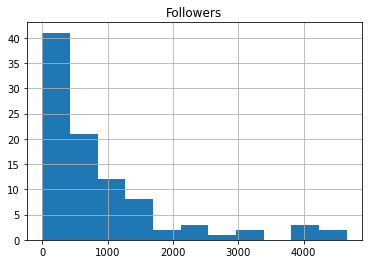

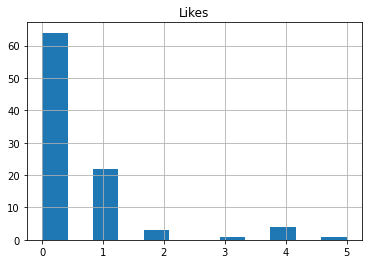

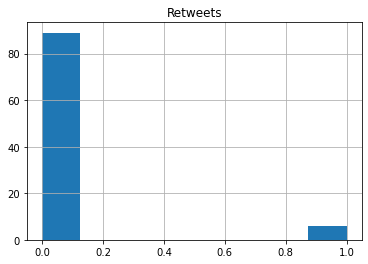

In [109]:
if __name__=="__main__":
    main()        